### SO here is the situation -- the required weather data is very hard to find for many locations for various metrics. For example, I haven't been able to find 24 precipitation for large portions of Canada. This emphasizes the need for alternative "reduced data" methods to determine the FWI. I'd like to try to build a machine learning model that can predict FWI based on temperature and wind speed alone (or some other combination).

In [1]:
import keras
import pandas as pd

In [2]:
singleDay = pd.read_csv("single_day_climate_data.csv")

# THese missing flags are actually mostly incorrect
#simpleDF=singleDay.query("TOTAL_PRECIPITATION_FLAG != 'M' and MEAN_TEMPERATURE_FLAG !='M' and SPEED_MAX_GUST_FLAG !='M' and MAX_REL_HUMIDITY_FLAG !='M'")

# Let's get the data for the stations that aren't missing any of the data (at least for this day)
simpleDF = singleDay.query("TOTAL_PRECIPITATION > -1000 and MEAN_TEMPERATURE > -1000 and SPEED_MAX_GUST > -1000 and MAX_REL_HUMIDITY > -1000")[['x','y','STATION_NAME','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION']]


In [3]:
import math
# “”” Define Class FWI Class first”””
class FWICLASS:
    def __init__(self,temp,rhum,wind,prcp):
        self.h = rhum
        self.t = temp
        self.w = wind
        self.p = prcp
    def FFMCcalc(self,ffmc0):
        mo = (147.2*(101.0 - ffmc0))/(59.5 + ffmc0) #*Eq. 1*#
        if (self.p > 0.5):
            rf = self.p - 0.5 #*Eq. 2*#%%!
            if(mo > 150.0):
                mo = (mo+42.5*rf*math.exp(-100.0/(251.0-mo))*(1.0 - math.exp(-6.93/rf))) + (.0015*(mo - 150.0)**2)*math.sqrt(rf) #*Eq. 3b*#
            elif mo <= 150.0:
                mo = mo+42.5*rf*math.exp(-100.0/(251.0-mo))*(1.0 - math.exp(-6.93/rf)) #*Eq. 3a*#
        if(mo > 250.0):
            mo = 250.0
        ed = .942*(self.h**.679) + (11.0*math.exp((self.h-100.0)/10.0))+0.18*(21.1-self.t)*(1.0 - 1.0/math.exp(.1150 * self.h)) #*Eq. 4*#
        if(mo < ed):
            ew = .618*(self.h**.753) + (10.0*math.exp((self.h-100.0)/10.0))+ .18*(21.1-self.t)*(1.0 - 1.0/math.exp(.115 * self.h)) #*Eq. 5*#
            if(mo <= ew):
                kl = .424*(1.0-((100.0-self.h)/100.0)**1.7)+(.0694*math.sqrt(self.w))*(1.0 - ((100.0 - self.h)/100.0)**8) #*Eq. 7a*#
                kw = kl * (.581 * math.exp(.0365 * self.t)) #*Eq. 7b*#
                m = ew - (ew - mo)/10.0**kw #*Eq. 9*#
            elif mo > ew:
                m = mo
        elif(mo == ed):
            m = mo
        elif mo > ed:
            kl =.424*(1.0-(self.h/100.0)**1.7)+(.0694*math.sqrt(self.w))* (1.0-(self.h/100.0)**8) #*Eq. 6a*#
            kw = kl * (.581*math.exp(.0365*self.t)) #*Eq. 6b*#
            m = ed + (mo-ed)/10.0 ** kw #*Eq. 8*#
        ffmc = (59.5 * (250.0 -m)) / (147.2 + m)
        if (ffmc > 101.0):
            ffmc = 101.0
        if (ffmc <= 0.0):
            ffmc = 0.0
        return ffmc
#*Eq. 10*#
    def DMCcalc(self,dmc0,mth):
        el = [6.5,7.5,9.0,12.8,13.9,13.9,12.4,10.9,9.4,8.0,7.0,6.0]
        t = self.t
        if (t < -1.1):
            t = -1.1
        rk = 1.894*(t+1.1) * (100.0-self.h) * (el[mth-1]*0.0001) #*Eqs. 16 and 17*#

        if self.p > 1.5:
            ra= self.p
            rw = 0.92*ra - 1.27
            wmi = 20.0 + 280.0/math.exp(0.023*dmc0)
            if dmc0 <= 33.0:
                b = 100.0 /(0.5 + 0.3*dmc0)
            elif dmc0 > 33.0:
                if dmc0 <= 65.0:
                    b = 14.0 - 1.3*math.log(dmc0)
            elif dmc0 > 65.0:
                b = 6.2 * math.log(dmc0) - 17.2
            wmr = wmi + (1000*rw) / (48.77+b*rw)
            pr = 43.43 * (5.6348 - math.log(wmr-20.0))
        elif self.p <= 1.5:
            pr = dmc0
        if (pr<0.0):
            pr = 0.0
        dmc = pr + rk
        if(dmc<= 1.0):
            dmc = 1.0
        return dmc


    def DCcalc(self,dc0,mth):
        fl = [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5.0, 2.4, 0.4, -1.6, -1.6]
        t = self.t
        if(t < -2.8):
            t = -2.8
        pe = (0.36*(t+2.8) + fl[mth-1] )/2
        if pe <=0.0:
            pe = 0.0
        #*Eq. 22*#
        if (self.p > 2.8):
            ra = self.p
            rw = 0.83*ra - 1.27 #*Eq. 18*#
            smi = 800.0 * math.exp(-dc0/400.0) #*Eq. 19*#
            dr = dc0 - 400.0*math.log( 1.0+((3.937*rw)/smi) ) #*Eqs. 20 and 21*#
            if (dr > 0.0):
                dc = dr + pe
            else: dc = dc0
        #elif self.p <= 2.8:
        else:
            dc = dc0 + pe
        return dc


    def ISIcalc(self,ffmc):
        mo = 147.2*(101.0-ffmc) / (59.5+ffmc)
        ff = 19.115*math.exp(mo*-0.1386) * (1.0+(mo**5.31)/49300000.0)
        isi = ff * math.exp(0.05039*self.w)
        return isi


    def BUIcalc(self,dmc,dc):
        if dmc <= 0.4*dc:
            bui = (0.8*dc*dmc) / (dmc+0.4*dc)
        else:
            bui = dmc-(1.0-0.8*dc/(dmc+0.4*dc))*(0.92+(0.0114*dmc)**1.7)
        if bui <0.0:
            bui = 0.0
        return bui


    def FWIcalc(self,isi,bui):
        if bui <= 80.0:
            bb = 0.1 * isi * (0.626*bui**0.809 + 2.0)
        else:
            bb = 0.1*isi*(1000.0/(25. + 108.64/math.exp(0.023*bui)))
        if(bb <= 1.0):
            fwi = bb
        else:
            fwi = math.exp(2.72 * (0.434*math.log(bb))**0.647)

        return fwi


def main():
    ffmc0 = 85.0
    dmc0 = 6.0
    dc0 = 15.0
    infile = open('test_in_fwi.txt','r')
    outfile = open('fwioutput.txt','w')
    try:
        for line in infile:
            mth,day,temp,rhum,wind,prcp=[float(field) for field in line.strip().lstrip('[').rstrip(']').split()]
            if rhum>100.0:
                rhum = 100.0
            mth = int(mth)
            fwisystem = FWICLASS(temp,rhum,wind,prcp)
            ffmc = fwisystem.FFMCcalc(ffmc0)
            dmc = fwisystem.DMCcalc(dmc0,mth)
            dc = fwisystem.DCcalc(dc0,mth)
            isi = fwisystem.ISIcalc(ffmc)
            bui = fwisystem.BUIcalc(dmc,dc)
            fwi = fwisystem.FWIcalc(isi,bui)
            ffmc0 = ffmc
            dmc0 = dmc
            dc0 = dc
            print(str(ffmc),str(dmc),str(dc),str(isi),str(bui),str(fwi))
    finally:
        infile.close()
        outfile.close()
main()

def computeFWI(temp,rhum,prcp,wind,mth):
    ffmc0 = 85.0
    dmc0 = 6.0
    dc0 = 15.0

    if rhum>100.0:
        rhum = 100.0
    mth = int(mth)
    fwisystem = FWICLASS(temp,rhum,wind,prcp)
    ffmc = fwisystem.FFMCcalc(ffmc0)
    dmc = fwisystem.DMCcalc(dmc0,mth)
    dc = fwisystem.DCcalc(dc0,mth)
    isi = fwisystem.ISIcalc(ffmc)
    bui = fwisystem.BUIcalc(dmc,dc)
    fwi = fwisystem.FWIcalc(isi,bui)
    ffmc0 = ffmc
    dmc0 = dmc
    dc0 = dc
    return fwi

# FROM https://publications.gc.ca/collections/collection_2016/rncan-nrcan/Fo133-1-424-eng.pdf

87.12550153156418 7.811796612 19.204 9.516918108321766 7.8039278404027135 8.705700639590445
90.8244737324999 11.674698630000002 25.028 10.802241217606626 11.60163827115898 11.549865177133597
77.63471875369589 11.112184754829832 27.49489140897453 1.5914554957643685 11.107277643541376 1.1193002660344609
90.21988710465098 16.188479766829833 35.29889140897453 13.40597459113381 16.121817741412364 15.890875255293292
65.31710438957165 9.79111185128955 23.010025331964645 1.3910938250537408 9.761933065289 0.8283486511031101
55.41626480735404 6.059921033103912 10.184518341592803 1.1877201080809798 5.87752455287238 0.549121999201251
80.84398999216936 9.667191765103912 16.368518341592804 1.8641589805082597 9.485649709445626 1.3929517266332863
61.741292230592016 7.150708726042811 17.26749308437178 1.2412291865095855 7.1345147457447196 0.6291345862151786
64.4820361685994 7.735685778042811 21.29149308437178 1.7303567635065653 8.107380366269709 0.9349073503101377
77.63396316147791 9.201024334042812 25

In [4]:
#OK let's output the state as a .csv just so we have SOMETHING)


#First, we need to compute the fwi
#Lets turn the data into a numpy array and then loop over it
numpysimpleDF = simpleDF[['MEAN_TEMPERATURE','MAX_REL_HUMIDITY','TOTAL_PRECIPITATION','SPEED_MAX_GUST']].to_numpy()

fwis = []
for i in range(len(numpysimpleDF)):
    fwis.append(computeFWI(numpysimpleDF[i][0],numpysimpleDF[i][1],numpysimpleDF[i][2],numpysimpleDF[i][3],11))

simpleDF["fwi"] = fwis
    
simpleDF.set_index("STATION_NAME")[['x','y','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION','fwi']].to_csv("Initial_State.csv")

In [5]:
print(f"These are all the {len(simpleDF)} stations that have all 4 types of data (at least on november 2 2023)")

# There are 351 stations that have this data -- it actually feels like too  many for me to go through manually and select them.
# What if I just take ALL station data from the last like 10 years or something and just filter out all the ones that are missing data?

for i in range(len(simpleDF.STATION_NAME)):
    print(simpleDF.STATION_NAME.sort_values().values[i])

These are all the 351 stations that have all 4 types of data (at least on november 2 2023)
ABBOTSFORD A
AGASSIZ RCS
ARGENTIA (AUT)
ARMSTRONG A
ARVIAT A
ARVIAT CLIMATE
ATTAWAPISKAT A
BACCARO PT
BADGER (AUT)
BAGOTVILLE A
BAIE-COMEAU
BAIE-COMEAU A
BAKER LAKE A
BAKER LAKE CLIMATE
BALLENAS ISLAND
BARRIE-ORO
BAS CARAQUET
BATHURST A
BATHURST INLET
BEATRICE CLIMATE
BEAUPORT
BEAVER MINES
BELLA BELLA
BELLA COOLA AIRPORT
BIG TROUT LAKE
BIG TROUT LAKE A
BONAVISTA
BONILLA ISLAND (AUT)
BOW VALLEY
BRANDON A
BRANTFORD AIRPORT
BRIER ISLAND
BROCKVILLE CLIMATE
BUFFALO NARROWS (AUT)
BUFFALO NARROWS A
BURGEO NL
CALGARY INT'L CS
CALGARY INTL A
CALGARY SPRINGBANK A
CAMBRIDGE BAY GSN
CAP-CHAT
CAP-MADELEINE
CAP-TOURMENTE
CAPE LIVERPOOL
CAPE ST JAMES
CARBERRY CS
CARIBOU ISLAND (AUT)
CARIBOU POINT (AUT)
CARTWRIGHT A
CATHEDRAL POINT (AUT)
CHARLEVOIX (MRC)
CHARLO AUTO
CHARLOTTETOWN A
CHATHAM KENT
CHETICAMP HIGHLANDS NATIONAL PARK
CHEVERY
CHIBOUGAMAU CHAPAIS A
CHIBOUGAMAU-CHAPAIS
CHURCHILL A
CHURCHILL CLIMATE
CLARE

In [6]:
simpleDF_on = singleDay.query("TOTAL_PRECIPITATION > -1000 and MEAN_TEMPERATURE > -1000 and SPEED_MAX_GUST > -1000 and MAX_REL_HUMIDITY > -1000 and PROVINCE_CODE=='ON'")[['x','y','STATION_NAME','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION']]
for i in range(len(simpleDF_on.STATION_NAME)):
    print(simpleDF_on.STATION_NAME.sort_values().values[i])

ARMSTRONG A
ATTAWAPISKAT A
BARRIE-ORO
BEATRICE CLIMATE
BIG TROUT LAKE
BIG TROUT LAKE A
BRANTFORD AIRPORT
BROCKVILLE CLIMATE
CARIBOU ISLAND (AUT)
CHATHAM KENT
COBOURG (AUT)
DELHI CS
DRYDEN REGIONAL
EARLTON A
EARLTON CLIMATE
EGBERT CS
ELORA RCS
FORT SEVERN A
GODERICH
GORE BAY CLIMATE
GORE BAY-MANITOULIN
HAMILTON A
HARROW CDA AUTO
KAPUSKASING A
KAPUSKASING CDA ON
KEMPTVILLE CS
KENORA A
KENORA RCS
KINGSTON CLIMATE
KITCHENER/WATERLOO
LANSDOWNE HOUSE (AUT)
LANSDOWNE HOUSE A
MONO CENTRE
MOOSE CREEK WELLS
MOOSONEE
MOUNT FOREST (AUT)
NORTH BAY A
NORTH BAY AIRPORT
OGOKI POST A
OSHAWA
OTTAWA CDA RCS
OTTAWA INTL A
PEAWANUCK (AUT)
PEAWANUCK A
PETERBOROUGH A
PICKLE LAKE (AUT)
PICKLE LAKE A
POINT PETRE (AUT)
PORT WELLER (AUT)
PUKASKWA (AUT)
RIDGETOWN RCS
SARNIA
SARNIA CLIMATE
SAULT STE MARIE A
SAULT STE. MARIE AIRPORT
SIOUX LOOKOUT A
SIOUX LOOKOUT AIRPORT
SUDBURY A
SUDBURY CLIMATE
TERRACE BAY AIRPORT
TIMMINS A
TIMMINS CLIMATE
TOBERMORY RCS
TORONTO CITY CENTRE
TORONTO INTL A
TRENTON A
UXBRIDGE WEST
VI

In [7]:
# OK I downloaded all data from the above stations from 2000 - 2023; lets load it in 

import glob
climateData = sorted(glob.glob("climate_daily_ontario_since_2000-reduced/*.csv"))
all_csv = []

for i in range(len(climateData)):
    
    #I'm just going to dropna from all of the data because at this point I'm running out of time to try to process it more involvedly.
    all_csv.append(pd.read_csv(climateData[i])[['x','y','LOCAL_DATE','STATION_NAME','MEAN_TEMPERATURE','MAX_REL_HUMIDITY','SPEED_MAX_GUST','TOTAL_PRECIPITATION']].dropna())

In [8]:
# Let's concat all of those to have one dataframe with everything.
full_df = pd.concat(all_csv).reset_index().drop("index",axis = 1)
full_df = full_df.dropna()
full_df = full_df.sort_values("STATION_NAME")
full_df = full_df.reset_index(drop = True)

# It is length 170,000.
# Honestly this is probably good enough to train a model of 4 parameters and one output.

In [9]:
full_df

,x,y,LOCAL_DATE,STATION_NAME,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,SPEED_MAX_GUST,TOTAL_PRECIPITATION
0,-88.909722,50.290278,2022-04-29 00:00:00,ARMSTRONG A,1.1,73.0,37.0,0.0
1,-88.909722,50.290278,2022-02-01 00:00:00,ARMSTRONG A,-10.2,97.0,63.0,0.2
2,-88.909722,50.290278,2022-02-02 00:00:00,ARMSTRONG A,-23.3,75.0,42.0,0.0
3,-88.909722,50.290278,2022-02-08 00:00:00,ARMSTRONG A,-8.9,96.0,46.0,0.0
4,-88.909722,50.290278,2022-02-10 00:00:00,ARMSTRONG A,-16.8,90.0,35.0,0.0
...,...,...,...,...,...,...,...,...
170484,-81.108611,44.744167,2021-03-08 00:00:00,WIARTON A,-1.6,93.0,45.0,0.0
170485,-81.108611,44.744167,2021-03-10 00:00:00,WIARTON A,7.4,67.0,51.0,0.0
170486,-81.108611,44.744167,2021-03-12 00:00:00,WIARTON A,-0.9,92.0,82.0,0.0
170487,-81.108611,44.744167,2021-02-23 00:00:00,WIARTON A,1.0,98.0,46.0,2.6


In [10]:
#First, we need to compute the fwi
#Lets turn the data into a numpy array and then loop over it
numpysimple_fullDF = full_df[['MEAN_TEMPERATURE','MAX_REL_HUMIDITY','TOTAL_PRECIPITATION','SPEED_MAX_GUST']].to_numpy()

fwis_full = []
for i in range(len(numpysimple_fullDF)):
    fwis_full.append(computeFWI(numpysimple_fullDF[i][0],numpysimple_fullDF[i][1],numpysimple_fullDF[i][2],numpysimple_fullDF[i][3],11))

full_df["fwi"] = fwis_full

#full_df.to_csv('ontariostations_2000_to_2023_t_s_p_fwi.csv')

In [11]:
full_df

,x,y,LOCAL_DATE,STATION_NAME,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,SPEED_MAX_GUST,TOTAL_PRECIPITATION,fwi
0,-88.909722,50.290278,2022-04-29 00:00:00,ARMSTRONG A,1.1,73.0,37.0,0.0,8.415498
1,-88.909722,50.290278,2022-02-01 00:00:00,ARMSTRONG A,-10.2,97.0,63.0,0.2,14.899067
2,-88.909722,50.290278,2022-02-02 00:00:00,ARMSTRONG A,-23.3,75.0,42.0,0.0,9.671279
3,-88.909722,50.290278,2022-02-08 00:00:00,ARMSTRONG A,-8.9,96.0,46.0,0.0,7.684838
4,-88.909722,50.290278,2022-02-10 00:00:00,ARMSTRONG A,-16.8,90.0,35.0,0.0,5.695663
...,...,...,...,...,...,...,...,...,...
170484,-81.108611,44.744167,2021-03-08 00:00:00,WIARTON A,-1.6,93.0,45.0,0.0,7.780153
170485,-81.108611,44.744167,2021-03-10 00:00:00,WIARTON A,7.4,67.0,51.0,0.0,17.317508
170486,-81.108611,44.744167,2021-03-12 00:00:00,WIARTON A,-0.9,92.0,82.0,0.0,31.715704
170487,-81.108611,44.744167,2021-02-23 00:00:00,WIARTON A,1.0,98.0,46.0,2.6,0.724868


In [12]:
### Ok now we need to build a DNN that learns to predict FWI from 3 parameters

# let's first scramble the dataframe to make sure we get a nice random order
full_df_scramble = full_df.sample(frac=1).reset_index(drop=True)

features_numpy = full_df_scramble[['MAX_REL_HUMIDITY','TOTAL_PRECIPITATION','SPEED_MAX_GUST']].to_numpy()
labels_numpy = full_df_scramble.fwi.values

In [13]:
train_features = features_numpy[:-int(len(features_numpy)/4)]
train_labels = labels_numpy[:-int(len(features_numpy)/4)]

test_features = features_numpy[-int(len(features_numpy)/4):]
test_labels = labels_numpy[-int(len(features_numpy)/4):]

In [23]:
import keras


model = keras.Sequential()
#we'll just flatten the one hot encoded sequence
model.add(keras.layers.Dense(3, input_shape=(3,), activation='leaky_relu'))
# Experimented with various hidden layers lead to this
model.add(keras.layers.Dense(25, activation='leaky_relu'))
model.add(keras.layers.Dense(25, activation='leaky_relu'))

model.add(keras.layers.Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

history=model.fit(train_features.reshape(-1,3),train_labels, epochs=5000, batch_size=10000,verbose = 1,validation_data=(test_features.reshape(-1,3), test_labels))


Epoch 1/5000
13/13 [==============================] - 0s 11ms/step - loss: 49.4407 - mean_squared_error: 49.4407 - val_loss: 45.2426 - val_mean_squared_error: 45.2426
Epoch 2/5000
13/13 [==============================] - 0s 4ms/step - loss: 30.2364 - mean_squared_error: 30.2364 - val_loss: 33.9316 - val_mean_squared_error: 33.9316
Epoch 3/5000
13/13 [==============================] - 0s 4ms/step - loss: 24.5179 - mean_squared_error: 24.5179 - val_loss: 28.8808 - val_mean_squared_error: 28.8808
Epoch 4/5000
13/13 [==============================] - 0s 4ms/step - loss: 21.0854 - mean_squared_error: 21.0854 - val_loss: 25.7183 - val_mean_squared_error: 25.7183
Epoch 5/5000
13/13 [==============================] - 0s 4ms/step - loss: 18.5039 - mean_squared_error: 18.5039 - val_loss: 23.4148 - val_mean_squared_error: 23.4148
Epoch 6/5000
13/13 [==============================] - 0s 4ms/step - loss: 16.5869 - mean_squared_error: 16.5869 - val_loss: 21.7175 - val_mean_squared_error: 21.7175
Epo

Epoch 51/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.1669 - mean_squared_error: 3.1669 - val_loss: 7.4471 - val_mean_squared_error: 7.4471
Epoch 52/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.1376 - mean_squared_error: 3.1376 - val_loss: 7.3563 - val_mean_squared_error: 7.3563
Epoch 53/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.0993 - mean_squared_error: 3.0993 - val_loss: 7.2984 - val_mean_squared_error: 7.2984
Epoch 54/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.0849 - mean_squared_error: 3.0849 - val_loss: 7.1988 - val_mean_squared_error: 7.1988
Epoch 55/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.0507 - mean_squared_error: 3.0507 - val_loss: 7.1245 - val_mean_squared_error: 7.1245
Epoch 56/5000
13/13 [==============================] - 0s 4ms/step - loss: 3.0115 - mean_squared_error: 3.0115 - val_loss: 7.0727 - val_mean_squared_error: 7.0727
Epoch 57/5000
13/13 [=

13/13 [==============================] - 0s 4ms/step - loss: 1.5805 - mean_squared_error: 1.5805 - val_loss: 2.9822 - val_mean_squared_error: 2.9822
Epoch 152/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.5914 - mean_squared_error: 1.5914 - val_loss: 2.9348 - val_mean_squared_error: 2.9348
Epoch 153/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.5766 - mean_squared_error: 1.5766 - val_loss: 2.9173 - val_mean_squared_error: 2.9173
Epoch 154/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.5737 - mean_squared_error: 1.5737 - val_loss: 2.9179 - val_mean_squared_error: 2.9179
Epoch 155/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.5684 - mean_squared_error: 1.5684 - val_loss: 2.9077 - val_mean_squared_error: 2.9077
Epoch 156/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.5575 - mean_squared_error: 1.5575 - val_loss: 2.9014 - val_mean_squared_error: 2.9014
Epoch 157/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.4324 - mean_squared_error: 1.4324 - val_loss: 2.4713 - val_mean_squared_error: 2.4713
Epoch 202/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.4356 - mean_squared_error: 1.4356 - val_loss: 2.4303 - val_mean_squared_error: 2.4303
Epoch 203/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.4080 - mean_squared_error: 1.4080 - val_loss: 2.4281 - val_mean_squared_error: 2.4281
Epoch 204/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.4139 - mean_squared_error: 1.4139 - val_loss: 2.4161 - val_mean_squared_error: 2.4161
Epoch 205/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.4236 - mean_squared_error: 1.4236 - val_loss: 2.4679 - val_mean_squared_error: 2.4679
Epoch 206/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.4339 - mean_squared_error: 1.4339 - val_loss: 2.3976 - val_mean_squared_error: 2.3976
Epoch 207/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.3438 - mean_squared_error: 1.3438 - val_loss: 2.1615 - val_mean_squared_error: 2.1615
Epoch 252/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.3326 - mean_squared_error: 1.3326 - val_loss: 2.1446 - val_mean_squared_error: 2.1446
Epoch 253/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.3499 - mean_squared_error: 1.3499 - val_loss: 2.1795 - val_mean_squared_error: 2.1795
Epoch 254/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.3667 - mean_squared_error: 1.3667 - val_loss: 2.2020 - val_mean_squared_error: 2.2020
Epoch 255/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.3786 - mean_squared_error: 1.3786 - val_loss: 2.1346 - val_mean_squared_error: 2.1346
Epoch 256/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.3289 - mean_squared_error: 1.3289 - val_loss: 2.1469 - val_mean_squared_error: 2.1469
Epoch 257/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.2739 - mean_squared_error: 1.2739 - val_loss: 1.9820 - val_mean_squared_error: 1.9820
Epoch 302/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2861 - mean_squared_error: 1.2861 - val_loss: 1.9660 - val_mean_squared_error: 1.9660
Epoch 303/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2901 - mean_squared_error: 1.2901 - val_loss: 1.9734 - val_mean_squared_error: 1.9734
Epoch 304/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2783 - mean_squared_error: 1.2783 - val_loss: 1.9594 - val_mean_squared_error: 1.9594
Epoch 305/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2826 - mean_squared_error: 1.2826 - val_loss: 1.9880 - val_mean_squared_error: 1.9880
Epoch 306/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2873 - mean_squared_error: 1.2873 - val_loss: 1.9556 - val_mean_squared_error: 1.9556
Epoch 307/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.2844 - mean_squared_error: 1.2844 - val_loss: 1.8691 - val_mean_squared_error: 1.8691
Epoch 352/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2555 - mean_squared_error: 1.2555 - val_loss: 1.8716 - val_mean_squared_error: 1.8716
Epoch 353/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2428 - mean_squared_error: 1.2428 - val_loss: 1.8456 - val_mean_squared_error: 1.8456
Epoch 354/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2339 - mean_squared_error: 1.2339 - val_loss: 1.8509 - val_mean_squared_error: 1.8509
Epoch 355/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2403 - mean_squared_error: 1.2403 - val_loss: 1.8710 - val_mean_squared_error: 1.8710
Epoch 356/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2401 - mean_squared_error: 1.2401 - val_loss: 1.8486 - val_mean_squared_error: 1.8486
Epoch 357/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.2219 - mean_squared_error: 1.2219 - val_loss: 1.7878 - val_mean_squared_error: 1.7878
Epoch 402/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2245 - mean_squared_error: 1.2245 - val_loss: 1.7797 - val_mean_squared_error: 1.7797
Epoch 403/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2150 - mean_squared_error: 1.2150 - val_loss: 1.7672 - val_mean_squared_error: 1.7672
Epoch 404/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2058 - mean_squared_error: 1.2058 - val_loss: 1.7729 - val_mean_squared_error: 1.7729
Epoch 405/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2304 - mean_squared_error: 1.2304 - val_loss: 1.7854 - val_mean_squared_error: 1.7854
Epoch 406/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.2086 - mean_squared_error: 1.2086 - val_loss: 1.7730 - val_mean_squared_error: 1.7730
Epoch 407/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.1985 - mean_squared_error: 1.1985 - val_loss: 1.7459 - val_mean_squared_error: 1.7459
Epoch 452/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1865 - mean_squared_error: 1.1865 - val_loss: 1.7142 - val_mean_squared_error: 1.7142
Epoch 453/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1797 - mean_squared_error: 1.1797 - val_loss: 1.6840 - val_mean_squared_error: 1.6840
Epoch 454/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1811 - mean_squared_error: 1.1811 - val_loss: 1.6909 - val_mean_squared_error: 1.6909
Epoch 455/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1944 - mean_squared_error: 1.1944 - val_loss: 1.7038 - val_mean_squared_error: 1.7038
Epoch 456/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1876 - mean_squared_error: 1.1876 - val_loss: 1.7256 - val_mean_squared_error: 1.7256
Epoch 457/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.1481 - mean_squared_error: 1.1481 - val_loss: 1.6482 - val_mean_squared_error: 1.6482
Epoch 502/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1505 - mean_squared_error: 1.1505 - val_loss: 1.6426 - val_mean_squared_error: 1.6426
Epoch 503/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1502 - mean_squared_error: 1.1502 - val_loss: 1.6561 - val_mean_squared_error: 1.6561
Epoch 504/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1636 - mean_squared_error: 1.1636 - val_loss: 1.6469 - val_mean_squared_error: 1.6469
Epoch 505/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1465 - mean_squared_error: 1.1465 - val_loss: 1.6480 - val_mean_squared_error: 1.6480
Epoch 506/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1489 - mean_squared_error: 1.1489 - val_loss: 1.6684 - val_mean_squared_error: 1.6684
Epoch 507/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.1233 - mean_squared_error: 1.1233 - val_loss: 1.5925 - val_mean_squared_error: 1.5925
Epoch 552/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1330 - mean_squared_error: 1.1330 - val_loss: 1.5898 - val_mean_squared_error: 1.5898
Epoch 553/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1281 - mean_squared_error: 1.1281 - val_loss: 1.6012 - val_mean_squared_error: 1.6012
Epoch 554/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1202 - mean_squared_error: 1.1202 - val_loss: 1.5939 - val_mean_squared_error: 1.5939
Epoch 555/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1487 - mean_squared_error: 1.1487 - val_loss: 1.6238 - val_mean_squared_error: 1.6238
Epoch 556/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1319 - mean_squared_error: 1.1319 - val_loss: 1.5655 - val_mean_squared_error: 1.5655
Epoch 557/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.0924 - mean_squared_error: 1.0924 - val_loss: 1.5309 - val_mean_squared_error: 1.5309
Epoch 602/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1081 - mean_squared_error: 1.1081 - val_loss: 1.5294 - val_mean_squared_error: 1.5294
Epoch 603/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0952 - mean_squared_error: 1.0952 - val_loss: 1.5132 - val_mean_squared_error: 1.5132
Epoch 604/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1030 - mean_squared_error: 1.1030 - val_loss: 1.5012 - val_mean_squared_error: 1.5012
Epoch 605/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1160 - mean_squared_error: 1.1160 - val_loss: 1.5332 - val_mean_squared_error: 1.5332
Epoch 606/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.1155 - mean_squared_error: 1.1155 - val_loss: 1.5311 - val_mean_squared_error: 1.5311
Epoch 607/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.0681 - mean_squared_error: 1.0681 - val_loss: 1.4627 - val_mean_squared_error: 1.4627
Epoch 652/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0749 - mean_squared_error: 1.0749 - val_loss: 1.4825 - val_mean_squared_error: 1.4825
Epoch 653/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0722 - mean_squared_error: 1.0722 - val_loss: 1.4526 - val_mean_squared_error: 1.4526
Epoch 654/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0751 - mean_squared_error: 1.0751 - val_loss: 1.5151 - val_mean_squared_error: 1.5151
Epoch 655/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0816 - mean_squared_error: 1.0816 - val_loss: 1.4952 - val_mean_squared_error: 1.4952
Epoch 656/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0763 - mean_squared_error: 1.0763 - val_loss: 1.4818 - val_mean_squared_error: 1.4818
Epoch 657/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.0433 - mean_squared_error: 1.0433 - val_loss: 1.4175 - val_mean_squared_error: 1.4175
Epoch 702/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0587 - mean_squared_error: 1.0587 - val_loss: 1.4912 - val_mean_squared_error: 1.4912
Epoch 703/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0631 - mean_squared_error: 1.0631 - val_loss: 1.4256 - val_mean_squared_error: 1.4256
Epoch 704/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0423 - mean_squared_error: 1.0423 - val_loss: 1.4063 - val_mean_squared_error: 1.4063
Epoch 705/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0445 - mean_squared_error: 1.0445 - val_loss: 1.4194 - val_mean_squared_error: 1.4194
Epoch 706/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0453 - mean_squared_error: 1.0453 - val_loss: 1.3998 - val_mean_squared_error: 1.3998
Epoch 707/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.0132 - mean_squared_error: 1.0132 - val_loss: 1.3657 - val_mean_squared_error: 1.3657
Epoch 752/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0204 - mean_squared_error: 1.0204 - val_loss: 1.3706 - val_mean_squared_error: 1.3706
Epoch 753/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0132 - mean_squared_error: 1.0132 - val_loss: 1.3648 - val_mean_squared_error: 1.3648
Epoch 754/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0295 - mean_squared_error: 1.0295 - val_loss: 1.4095 - val_mean_squared_error: 1.4095
Epoch 755/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 1.3718 - val_mean_squared_error: 1.3718
Epoch 756/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0178 - mean_squared_error: 1.0178 - val_loss: 1.3530 - val_mean_squared_error: 1.3530
Epoch 757/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 1.0035 - mean_squared_error: 1.0035 - val_loss: 1.3295 - val_mean_squared_error: 1.3295
Epoch 802/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0011 - mean_squared_error: 1.0011 - val_loss: 1.3422 - val_mean_squared_error: 1.3422
Epoch 803/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0231 - mean_squared_error: 1.0231 - val_loss: 1.3605 - val_mean_squared_error: 1.3605
Epoch 804/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0211 - mean_squared_error: 1.0211 - val_loss: 1.3637 - val_mean_squared_error: 1.3637
Epoch 805/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0254 - mean_squared_error: 1.0254 - val_loss: 1.3351 - val_mean_squared_error: 1.3351
Epoch 806/5000
13/13 [==============================] - 0s 4ms/step - loss: 1.0027 - mean_squared_error: 1.0027 - val_loss: 1.3134 - val_mean_squared_error: 1.3134
Epoch 807/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 0.9852 - mean_squared_error: 0.9852 - val_loss: 1.3157 - val_mean_squared_error: 1.3157
Epoch 852/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9801 - mean_squared_error: 0.9801 - val_loss: 1.2958 - val_mean_squared_error: 1.2958
Epoch 853/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9778 - mean_squared_error: 0.9778 - val_loss: 1.2901 - val_mean_squared_error: 1.2901
Epoch 854/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9697 - mean_squared_error: 0.9697 - val_loss: 1.2936 - val_mean_squared_error: 1.2936
Epoch 855/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9709 - mean_squared_error: 0.9709 - val_loss: 1.3246 - val_mean_squared_error: 1.3246
Epoch 856/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9787 - mean_squared_error: 0.9787 - val_loss: 1.3107 - val_mean_squared_error: 1.3107
Epoch 857/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 0.9611 - mean_squared_error: 0.9611 - val_loss: 1.2903 - val_mean_squared_error: 1.2903
Epoch 902/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9664 - mean_squared_error: 0.9664 - val_loss: 1.2709 - val_mean_squared_error: 1.2709
Epoch 903/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9733 - mean_squared_error: 0.9733 - val_loss: 1.2798 - val_mean_squared_error: 1.2798
Epoch 904/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9643 - mean_squared_error: 0.9643 - val_loss: 1.2498 - val_mean_squared_error: 1.2498
Epoch 905/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9638 - mean_squared_error: 0.9638 - val_loss: 1.2433 - val_mean_squared_error: 1.2433
Epoch 906/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9541 - mean_squared_error: 0.9541 - val_loss: 1.2669 - val_mean_squared_error: 1.2669
Epoch 907/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 0.9502 - mean_squared_error: 0.9502 - val_loss: 1.3079 - val_mean_squared_error: 1.3079
Epoch 952/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9613 - mean_squared_error: 0.9613 - val_loss: 1.2442 - val_mean_squared_error: 1.2442
Epoch 953/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9419 - mean_squared_error: 0.9419 - val_loss: 1.2487 - val_mean_squared_error: 1.2487
Epoch 954/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9569 - mean_squared_error: 0.9569 - val_loss: 1.2303 - val_mean_squared_error: 1.2303
Epoch 955/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9554 - mean_squared_error: 0.9554 - val_loss: 1.2296 - val_mean_squared_error: 1.2296
Epoch 956/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9414 - mean_squared_error: 0.9414 - val_loss: 1.2420 - val_mean_squared_error: 1.2420
Epoch 957/5000
13/13 [=========

13/13 [==============================] - 0s 4ms/step - loss: 0.9499 - mean_squared_error: 0.9499 - val_loss: 1.2294 - val_mean_squared_error: 1.2294
Epoch 1002/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9418 - mean_squared_error: 0.9418 - val_loss: 1.2419 - val_mean_squared_error: 1.2419
Epoch 1003/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9277 - mean_squared_error: 0.9277 - val_loss: 1.2391 - val_mean_squared_error: 1.2391
Epoch 1004/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9482 - mean_squared_error: 0.9482 - val_loss: 1.2037 - val_mean_squared_error: 1.2037
Epoch 1005/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.9327 - mean_squared_error: 0.9327 - val_loss: 1.1929 - val_mean_squared_error: 1.1929
Epoch 1006/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9419 - mean_squared_error: 0.9419 - val_loss: 1.2644 - val_mean_squared_error: 1.2644
Epoch 1007/5000
13/13 [===

Epoch 1051/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9179 - mean_squared_error: 0.9179 - val_loss: 1.1971 - val_mean_squared_error: 1.1971
Epoch 1052/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9447 - mean_squared_error: 0.9447 - val_loss: 1.2540 - val_mean_squared_error: 1.2540
Epoch 1053/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9509 - mean_squared_error: 0.9509 - val_loss: 1.2575 - val_mean_squared_error: 1.2575
Epoch 1054/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9276 - mean_squared_error: 0.9276 - val_loss: 1.1877 - val_mean_squared_error: 1.1877
Epoch 1055/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9139 - mean_squared_error: 0.9139 - val_loss: 1.1904 - val_mean_squared_error: 1.1904
Epoch 1056/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9214 - mean_squared_error: 0.9214 - val_loss: 1.2336 - val_mean_squared_error: 1.2336
Epoch 1057

Epoch 1150/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.8943 - mean_squared_error: 0.8943 - val_loss: 1.1634 - val_mean_squared_error: 1.1634
Epoch 1151/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8997 - mean_squared_error: 0.8997 - val_loss: 1.2107 - val_mean_squared_error: 1.2107
Epoch 1152/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8984 - mean_squared_error: 0.8984 - val_loss: 1.1664 - val_mean_squared_error: 1.1664
Epoch 1153/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8866 - mean_squared_error: 0.8866 - val_loss: 1.1461 - val_mean_squared_error: 1.1461
Epoch 1154/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8922 - mean_squared_error: 0.8922 - val_loss: 1.1288 - val_mean_squared_error: 1.1288
Epoch 1155/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8951 - mean_squared_error: 0.8951 - val_loss: 1.1758 - val_mean_squared_error: 1.1758
Epoch 1156

Epoch 1249/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.9326 - mean_squared_error: 0.9326 - val_loss: 1.1291 - val_mean_squared_error: 1.1291
Epoch 1250/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8857 - mean_squared_error: 0.8857 - val_loss: 1.1210 - val_mean_squared_error: 1.1210
Epoch 1251/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8871 - mean_squared_error: 0.8871 - val_loss: 1.1629 - val_mean_squared_error: 1.1629
Epoch 1252/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8758 - mean_squared_error: 0.8758 - val_loss: 1.1264 - val_mean_squared_error: 1.1264
Epoch 1253/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8689 - mean_squared_error: 0.8689 - val_loss: 1.1211 - val_mean_squared_error: 1.1211
Epoch 1254/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8718 - mean_squared_error: 0.8718 - val_loss: 1.1437 - val_mean_squared_error: 1.1437
Epoch 1255

Epoch 1348/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8753 - mean_squared_error: 0.8753 - val_loss: 1.1518 - val_mean_squared_error: 1.1518
Epoch 1349/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8889 - mean_squared_error: 0.8889 - val_loss: 1.1981 - val_mean_squared_error: 1.1981
Epoch 1350/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8821 - mean_squared_error: 0.8821 - val_loss: 1.0795 - val_mean_squared_error: 1.0795
Epoch 1351/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8681 - mean_squared_error: 0.8681 - val_loss: 1.0976 - val_mean_squared_error: 1.0976
Epoch 1352/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8719 - mean_squared_error: 0.8719 - val_loss: 1.1272 - val_mean_squared_error: 1.1272
Epoch 1353/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8866 - mean_squared_error: 0.8866 - val_loss: 1.0765 - val_mean_squared_error: 1.0765
Epoch 1354

Epoch 1447/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8470 - mean_squared_error: 0.8470 - val_loss: 1.0958 - val_mean_squared_error: 1.0958
Epoch 1448/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8481 - mean_squared_error: 0.8481 - val_loss: 1.1131 - val_mean_squared_error: 1.1131
Epoch 1449/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8766 - mean_squared_error: 0.8766 - val_loss: 1.1429 - val_mean_squared_error: 1.1429
Epoch 1450/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8760 - mean_squared_error: 0.8760 - val_loss: 1.0876 - val_mean_squared_error: 1.0876
Epoch 1451/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8545 - mean_squared_error: 0.8545 - val_loss: 1.0980 - val_mean_squared_error: 1.0980
Epoch 1452/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8621 - mean_squared_error: 0.8621 - val_loss: 1.1255 - val_mean_squared_error: 1.1255
Epoch 1453

Epoch 1546/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8801 - mean_squared_error: 0.8801 - val_loss: 1.0902 - val_mean_squared_error: 1.0902
Epoch 1547/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8446 - mean_squared_error: 0.8446 - val_loss: 1.0931 - val_mean_squared_error: 1.0931
Epoch 1548/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8432 - mean_squared_error: 0.8432 - val_loss: 1.0836 - val_mean_squared_error: 1.0836
Epoch 1549/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8340 - mean_squared_error: 0.8340 - val_loss: 1.0685 - val_mean_squared_error: 1.0685
Epoch 1550/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8342 - mean_squared_error: 0.8342 - val_loss: 1.0917 - val_mean_squared_error: 1.0917
Epoch 1551/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8501 - mean_squared_error: 0.8501 - val_loss: 1.0884 - val_mean_squared_error: 1.0884
Epoch 1552

Epoch 1645/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8543 - mean_squared_error: 0.8543 - val_loss: 1.1360 - val_mean_squared_error: 1.1360
Epoch 1646/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8423 - mean_squared_error: 0.8423 - val_loss: 1.0970 - val_mean_squared_error: 1.0970
Epoch 1647/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8305 - mean_squared_error: 0.8305 - val_loss: 1.0779 - val_mean_squared_error: 1.0779
Epoch 1648/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8252 - mean_squared_error: 0.8252 - val_loss: 1.0913 - val_mean_squared_error: 1.0913
Epoch 1649/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8358 - mean_squared_error: 0.8358 - val_loss: 1.0643 - val_mean_squared_error: 1.0643
Epoch 1650/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8243 - mean_squared_error: 0.8243 - val_loss: 1.0871 - val_mean_squared_error: 1.0871
Epoch 1651

Epoch 1744/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8228 - mean_squared_error: 0.8228 - val_loss: 1.0819 - val_mean_squared_error: 1.0819
Epoch 1745/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.8187 - mean_squared_error: 0.8187 - val_loss: 1.0422 - val_mean_squared_error: 1.0422
Epoch 1746/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8054 - mean_squared_error: 0.8054 - val_loss: 1.0878 - val_mean_squared_error: 1.0878
Epoch 1747/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8066 - mean_squared_error: 0.8066 - val_loss: 1.0922 - val_mean_squared_error: 1.0922
Epoch 1748/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8312 - mean_squared_error: 0.8312 - val_loss: 1.0457 - val_mean_squared_error: 1.0457
Epoch 1749/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8351 - mean_squared_error: 0.8351 - val_loss: 1.1282 - val_mean_squared_error: 1.1282
Epoch 1750

Epoch 1843/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7977 - mean_squared_error: 0.7977 - val_loss: 1.0886 - val_mean_squared_error: 1.0886
Epoch 1844/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7933 - mean_squared_error: 0.7933 - val_loss: 1.0535 - val_mean_squared_error: 1.0535
Epoch 1845/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8030 - mean_squared_error: 0.8030 - val_loss: 1.0667 - val_mean_squared_error: 1.0667
Epoch 1846/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7876 - mean_squared_error: 0.7876 - val_loss: 1.0640 - val_mean_squared_error: 1.0640
Epoch 1847/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8013 - mean_squared_error: 0.8013 - val_loss: 1.0817 - val_mean_squared_error: 1.0817
Epoch 1848/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8144 - mean_squared_error: 0.8144 - val_loss: 1.0649 - val_mean_squared_error: 1.0649
Epoch 1849

Epoch 1942/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7725 - mean_squared_error: 0.7725 - val_loss: 1.0301 - val_mean_squared_error: 1.0301
Epoch 1943/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7884 - mean_squared_error: 0.7884 - val_loss: 1.0585 - val_mean_squared_error: 1.0585
Epoch 1944/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8238 - mean_squared_error: 0.8238 - val_loss: 1.0507 - val_mean_squared_error: 1.0507
Epoch 1945/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7902 - mean_squared_error: 0.7902 - val_loss: 1.1011 - val_mean_squared_error: 1.1011
Epoch 1946/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8142 - mean_squared_error: 0.8142 - val_loss: 1.1272 - val_mean_squared_error: 1.1272
Epoch 1947/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8074 - mean_squared_error: 0.8074 - val_loss: 1.0813 - val_mean_squared_error: 1.0813
Epoch 1948

Epoch 2041/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7770 - mean_squared_error: 0.7770 - val_loss: 1.1132 - val_mean_squared_error: 1.1132
Epoch 2042/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7974 - mean_squared_error: 0.7974 - val_loss: 1.0625 - val_mean_squared_error: 1.0625
Epoch 2043/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.8189 - mean_squared_error: 0.8189 - val_loss: 1.0151 - val_mean_squared_error: 1.0151
Epoch 2044/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7798 - mean_squared_error: 0.7798 - val_loss: 1.0156 - val_mean_squared_error: 1.0156
Epoch 2045/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7700 - mean_squared_error: 0.7700 - val_loss: 1.0290 - val_mean_squared_error: 1.0290
Epoch 2046/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7641 - mean_squared_error: 0.7641 - val_loss: 1.0163 - val_mean_squared_error: 1.0163
Epoch 2047

Epoch 2140/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7804 - mean_squared_error: 0.7804 - val_loss: 1.0254 - val_mean_squared_error: 1.0254
Epoch 2141/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7589 - mean_squared_error: 0.7589 - val_loss: 1.0299 - val_mean_squared_error: 1.0299
Epoch 2142/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7701 - mean_squared_error: 0.7701 - val_loss: 1.0561 - val_mean_squared_error: 1.0561
Epoch 2143/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.7849 - mean_squared_error: 0.7849 - val_loss: 1.0231 - val_mean_squared_error: 1.0231
Epoch 2144/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7945 - mean_squared_error: 0.7945 - val_loss: 1.0713 - val_mean_squared_error: 1.0713
Epoch 2145/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7807 - mean_squared_error: 0.7807 - val_loss: 0.9779 - val_mean_squared_error: 0.9779
Epoch 2146

Epoch 2239/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7598 - mean_squared_error: 0.7598 - val_loss: 1.0328 - val_mean_squared_error: 1.0328
Epoch 2240/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7698 - mean_squared_error: 0.7698 - val_loss: 0.9821 - val_mean_squared_error: 0.9821
Epoch 2241/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7579 - mean_squared_error: 0.7579 - val_loss: 0.9900 - val_mean_squared_error: 0.9900
Epoch 2242/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7379 - mean_squared_error: 0.7379 - val_loss: 1.0057 - val_mean_squared_error: 1.0057
Epoch 2243/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7617 - mean_squared_error: 0.7617 - val_loss: 0.9756 - val_mean_squared_error: 0.9756
Epoch 2244/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7805 - mean_squared_error: 0.7805 - val_loss: 1.0148 - val_mean_squared_error: 1.0148
Epoch 2245

Epoch 2338/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7602 - mean_squared_error: 0.7602 - val_loss: 0.9964 - val_mean_squared_error: 0.9964
Epoch 2339/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7361 - mean_squared_error: 0.7361 - val_loss: 0.9831 - val_mean_squared_error: 0.9831
Epoch 2340/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7315 - mean_squared_error: 0.7315 - val_loss: 0.9797 - val_mean_squared_error: 0.9797
Epoch 2341/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7417 - mean_squared_error: 0.7417 - val_loss: 0.9971 - val_mean_squared_error: 0.9971
Epoch 2342/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7332 - mean_squared_error: 0.7332 - val_loss: 0.9932 - val_mean_squared_error: 0.9932
Epoch 2343/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7420 - mean_squared_error: 0.7420 - val_loss: 1.0165 - val_mean_squared_error: 1.0165
Epoch 2344

Epoch 2437/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7434 - mean_squared_error: 0.7434 - val_loss: 0.9833 - val_mean_squared_error: 0.9833
Epoch 2438/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7138 - mean_squared_error: 0.7138 - val_loss: 0.9585 - val_mean_squared_error: 0.9585
Epoch 2439/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7054 - mean_squared_error: 0.7054 - val_loss: 0.9610 - val_mean_squared_error: 0.9610
Epoch 2440/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7112 - mean_squared_error: 0.7112 - val_loss: 0.9893 - val_mean_squared_error: 0.9893
Epoch 2441/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7177 - mean_squared_error: 0.7177 - val_loss: 1.0149 - val_mean_squared_error: 1.0149
Epoch 2442/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7287 - mean_squared_error: 0.7287 - val_loss: 0.9404 - val_mean_squared_error: 0.9404
Epoch 2443

Epoch 2536/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7135 - mean_squared_error: 0.7135 - val_loss: 0.9605 - val_mean_squared_error: 0.9605
Epoch 2537/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.7193 - mean_squared_error: 0.7193 - val_loss: 0.9603 - val_mean_squared_error: 0.9603
Epoch 2538/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7345 - mean_squared_error: 0.7345 - val_loss: 1.0049 - val_mean_squared_error: 1.0049
Epoch 2539/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7310 - mean_squared_error: 0.7310 - val_loss: 1.0081 - val_mean_squared_error: 1.0081
Epoch 2540/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.9275 - val_mean_squared_error: 0.9275
Epoch 2541/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7324 - mean_squared_error: 0.7324 - val_loss: 0.9870 - val_mean_squared_error: 0.9870
Epoch 2542

Epoch 2635/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7125 - mean_squared_error: 0.7125 - val_loss: 1.0412 - val_mean_squared_error: 1.0412
Epoch 2636/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7238 - mean_squared_error: 0.7238 - val_loss: 0.9237 - val_mean_squared_error: 0.9237
Epoch 2637/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6945 - mean_squared_error: 0.6945 - val_loss: 0.9457 - val_mean_squared_error: 0.9457
Epoch 2638/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7027 - mean_squared_error: 0.7027 - val_loss: 1.0007 - val_mean_squared_error: 1.0007
Epoch 2639/5000
13/13 [==============================] - 0s 5ms/step - loss: 0.7066 - mean_squared_error: 0.7066 - val_loss: 0.9494 - val_mean_squared_error: 0.9494
Epoch 2640/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6943 - mean_squared_error: 0.6943 - val_loss: 0.9373 - val_mean_squared_error: 0.9373
Epoch 2641

Epoch 2734/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6953 - mean_squared_error: 0.6953 - val_loss: 1.0150 - val_mean_squared_error: 1.0150
Epoch 2735/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7237 - mean_squared_error: 0.7237 - val_loss: 0.9522 - val_mean_squared_error: 0.9522
Epoch 2736/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7058 - mean_squared_error: 0.7058 - val_loss: 0.9418 - val_mean_squared_error: 0.9418
Epoch 2737/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6913 - mean_squared_error: 0.6913 - val_loss: 0.9410 - val_mean_squared_error: 0.9410
Epoch 2738/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6965 - mean_squared_error: 0.6965 - val_loss: 0.9563 - val_mean_squared_error: 0.9563
Epoch 2739/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6973 - mean_squared_error: 0.6973 - val_loss: 0.9400 - val_mean_squared_error: 0.9400
Epoch 2740

Epoch 2833/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7061 - mean_squared_error: 0.7061 - val_loss: 0.9648 - val_mean_squared_error: 0.9648
Epoch 2834/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6926 - mean_squared_error: 0.6926 - val_loss: 0.9273 - val_mean_squared_error: 0.9273
Epoch 2835/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6980 - mean_squared_error: 0.6980 - val_loss: 0.9544 - val_mean_squared_error: 0.9544
Epoch 2836/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6867 - mean_squared_error: 0.6867 - val_loss: 0.9355 - val_mean_squared_error: 0.9355
Epoch 2837/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6992 - mean_squared_error: 0.6992 - val_loss: 0.9157 - val_mean_squared_error: 0.9157
Epoch 2838/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6940 - mean_squared_error: 0.6940 - val_loss: 0.9519 - val_mean_squared_error: 0.9519
Epoch 2839

Epoch 2932/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6997 - mean_squared_error: 0.6997 - val_loss: 0.9359 - val_mean_squared_error: 0.9359
Epoch 2933/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6946 - mean_squared_error: 0.6946 - val_loss: 0.9812 - val_mean_squared_error: 0.9812
Epoch 2934/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7136 - mean_squared_error: 0.7136 - val_loss: 0.9222 - val_mean_squared_error: 0.9222
Epoch 2935/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7024 - mean_squared_error: 0.7024 - val_loss: 0.9588 - val_mean_squared_error: 0.9588
Epoch 2936/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6947 - mean_squared_error: 0.6947 - val_loss: 0.9262 - val_mean_squared_error: 0.9262
Epoch 2937/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7029 - mean_squared_error: 0.7029 - val_loss: 0.9643 - val_mean_squared_error: 0.9643
Epoch 2938

Epoch 3031/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6810 - mean_squared_error: 0.6810 - val_loss: 0.9272 - val_mean_squared_error: 0.9272
Epoch 3032/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7049 - mean_squared_error: 0.7049 - val_loss: 0.9746 - val_mean_squared_error: 0.9746
Epoch 3033/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6976 - mean_squared_error: 0.6976 - val_loss: 0.9436 - val_mean_squared_error: 0.9436
Epoch 3034/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6852 - mean_squared_error: 0.6852 - val_loss: 0.9466 - val_mean_squared_error: 0.9466
Epoch 3035/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6809 - mean_squared_error: 0.6809 - val_loss: 0.9447 - val_mean_squared_error: 0.9447
Epoch 3036/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6790 - mean_squared_error: 0.6790 - val_loss: 0.9547 - val_mean_squared_error: 0.9547
Epoch 3037

Epoch 3130/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6890 - mean_squared_error: 0.6890 - val_loss: 0.9244 - val_mean_squared_error: 0.9244
Epoch 3131/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6755 - mean_squared_error: 0.6755 - val_loss: 0.9260 - val_mean_squared_error: 0.9260
Epoch 3132/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6830 - mean_squared_error: 0.6830 - val_loss: 1.0068 - val_mean_squared_error: 1.0068
Epoch 3133/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7036 - mean_squared_error: 0.7036 - val_loss: 0.9196 - val_mean_squared_error: 0.9196
Epoch 3134/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6978 - mean_squared_error: 0.6978 - val_loss: 0.9644 - val_mean_squared_error: 0.9644
Epoch 3135/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6737 - mean_squared_error: 0.6737 - val_loss: 0.9633 - val_mean_squared_error: 0.9633
Epoch 3136

Epoch 3229/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6710 - mean_squared_error: 0.6710 - val_loss: 0.9408 - val_mean_squared_error: 0.9408
Epoch 3230/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6737 - mean_squared_error: 0.6737 - val_loss: 0.9551 - val_mean_squared_error: 0.9551
Epoch 3231/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6964 - mean_squared_error: 0.6964 - val_loss: 1.0088 - val_mean_squared_error: 1.0088
Epoch 3232/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.7343 - mean_squared_error: 0.7343 - val_loss: 0.9420 - val_mean_squared_error: 0.9420
Epoch 3233/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6807 - mean_squared_error: 0.6807 - val_loss: 0.9227 - val_mean_squared_error: 0.9227
Epoch 3234/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6855 - mean_squared_error: 0.6855 - val_loss: 0.9290 - val_mean_squared_error: 0.9290
Epoch 3235

Epoch 3328/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6670 - mean_squared_error: 0.6670 - val_loss: 0.9224 - val_mean_squared_error: 0.9224
Epoch 3329/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6750 - mean_squared_error: 0.6750 - val_loss: 0.9704 - val_mean_squared_error: 0.9704
Epoch 3330/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6751 - mean_squared_error: 0.6751 - val_loss: 0.9186 - val_mean_squared_error: 0.9186
Epoch 3331/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6612 - mean_squared_error: 0.6612 - val_loss: 0.9470 - val_mean_squared_error: 0.9470
Epoch 3332/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6692 - mean_squared_error: 0.6692 - val_loss: 0.9611 - val_mean_squared_error: 0.9611
Epoch 3333/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6728 - mean_squared_error: 0.6728 - val_loss: 0.9468 - val_mean_squared_error: 0.9468
Epoch 3334

Epoch 3427/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6566 - mean_squared_error: 0.6566 - val_loss: 0.9550 - val_mean_squared_error: 0.9550
Epoch 3428/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6543 - mean_squared_error: 0.6543 - val_loss: 0.9159 - val_mean_squared_error: 0.9159
Epoch 3429/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6522 - mean_squared_error: 0.6522 - val_loss: 0.9197 - val_mean_squared_error: 0.9197
Epoch 3430/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6643 - mean_squared_error: 0.6643 - val_loss: 1.0335 - val_mean_squared_error: 1.0335
Epoch 3431/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6744 - mean_squared_error: 0.6744 - val_loss: 0.9753 - val_mean_squared_error: 0.9753
Epoch 3432/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6591 - mean_squared_error: 0.6591 - val_loss: 0.9301 - val_mean_squared_error: 0.9301
Epoch 3433

Epoch 3526/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6611 - mean_squared_error: 0.6611 - val_loss: 0.9858 - val_mean_squared_error: 0.9858
Epoch 3527/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6501 - mean_squared_error: 0.6501 - val_loss: 0.9356 - val_mean_squared_error: 0.9356
Epoch 3528/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6556 - mean_squared_error: 0.6556 - val_loss: 0.9527 - val_mean_squared_error: 0.9527
Epoch 3529/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6591 - mean_squared_error: 0.6591 - val_loss: 1.0099 - val_mean_squared_error: 1.0099
Epoch 3530/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6714 - mean_squared_error: 0.6714 - val_loss: 0.9377 - val_mean_squared_error: 0.9377
Epoch 3531/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6549 - mean_squared_error: 0.6549 - val_loss: 0.9275 - val_mean_squared_error: 0.9275
Epoch 3532

Epoch 3625/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6854 - mean_squared_error: 0.6854 - val_loss: 0.9353 - val_mean_squared_error: 0.9353
Epoch 3626/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.9368 - val_mean_squared_error: 0.9368
Epoch 3627/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6496 - mean_squared_error: 0.6496 - val_loss: 0.9887 - val_mean_squared_error: 0.9887
Epoch 3628/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6451 - mean_squared_error: 0.6451 - val_loss: 0.9527 - val_mean_squared_error: 0.9527
Epoch 3629/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6551 - mean_squared_error: 0.6551 - val_loss: 0.9247 - val_mean_squared_error: 0.9247
Epoch 3630/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6553 - mean_squared_error: 0.6553 - val_loss: 0.9927 - val_mean_squared_error: 0.9927
Epoch 3631

Epoch 3724/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6590 - mean_squared_error: 0.6590 - val_loss: 0.9313 - val_mean_squared_error: 0.9313
Epoch 3725/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6466 - mean_squared_error: 0.6466 - val_loss: 0.9340 - val_mean_squared_error: 0.9340
Epoch 3726/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6441 - mean_squared_error: 0.6441 - val_loss: 0.9491 - val_mean_squared_error: 0.9491
Epoch 3727/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6444 - mean_squared_error: 0.6444 - val_loss: 0.9386 - val_mean_squared_error: 0.9386
Epoch 3728/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6616 - mean_squared_error: 0.6616 - val_loss: 0.9574 - val_mean_squared_error: 0.9574
Epoch 3729/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6538 - mean_squared_error: 0.6538 - val_loss: 0.9488 - val_mean_squared_error: 0.9488
Epoch 3730

Epoch 3823/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.9501 - val_mean_squared_error: 0.9501
Epoch 3824/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6329 - mean_squared_error: 0.6329 - val_loss: 0.9632 - val_mean_squared_error: 0.9632
Epoch 3825/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6556 - mean_squared_error: 0.6556 - val_loss: 0.8984 - val_mean_squared_error: 0.8984
Epoch 3826/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6435 - mean_squared_error: 0.6435 - val_loss: 0.9396 - val_mean_squared_error: 0.9396
Epoch 3827/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6442 - mean_squared_error: 0.6442 - val_loss: 0.9574 - val_mean_squared_error: 0.9574
Epoch 3828/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6353 - mean_squared_error: 0.6353 - val_loss: 0.9526 - val_mean_squared_error: 0.9526
Epoch 3829

Epoch 3922/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6446 - mean_squared_error: 0.6446 - val_loss: 0.9118 - val_mean_squared_error: 0.9118
Epoch 3923/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6290 - mean_squared_error: 0.6290 - val_loss: 0.9223 - val_mean_squared_error: 0.9223
Epoch 3924/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6264 - mean_squared_error: 0.6264 - val_loss: 0.9407 - val_mean_squared_error: 0.9407
Epoch 3925/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6559 - mean_squared_error: 0.6559 - val_loss: 0.9671 - val_mean_squared_error: 0.9671
Epoch 3926/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6626 - mean_squared_error: 0.6626 - val_loss: 0.9305 - val_mean_squared_error: 0.9305
Epoch 3927/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6435 - mean_squared_error: 0.6435 - val_loss: 0.9619 - val_mean_squared_error: 0.9619
Epoch 3928

Epoch 4021/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6562 - mean_squared_error: 0.6562 - val_loss: 0.9475 - val_mean_squared_error: 0.9475
Epoch 4022/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6542 - mean_squared_error: 0.6542 - val_loss: 0.9035 - val_mean_squared_error: 0.9035
Epoch 4023/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6152 - mean_squared_error: 0.6152 - val_loss: 0.9102 - val_mean_squared_error: 0.9102
Epoch 4024/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6430 - mean_squared_error: 0.6430 - val_loss: 0.9794 - val_mean_squared_error: 0.9794
Epoch 4025/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6671 - mean_squared_error: 0.6671 - val_loss: 1.0291 - val_mean_squared_error: 1.0291
Epoch 4026/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6558 - mean_squared_error: 0.6558 - val_loss: 0.8904 - val_mean_squared_error: 0.8904
Epoch 4027

Epoch 4120/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6181 - mean_squared_error: 0.6181 - val_loss: 0.9288 - val_mean_squared_error: 0.9288
Epoch 4121/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6197 - mean_squared_error: 0.6197 - val_loss: 0.9178 - val_mean_squared_error: 0.9178
Epoch 4122/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6148 - mean_squared_error: 0.6148 - val_loss: 0.9461 - val_mean_squared_error: 0.9461
Epoch 4123/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6271 - mean_squared_error: 0.6271 - val_loss: 0.9121 - val_mean_squared_error: 0.9121
Epoch 4124/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6196 - mean_squared_error: 0.6196 - val_loss: 0.8900 - val_mean_squared_error: 0.8900
Epoch 4125/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6468 - mean_squared_error: 0.6468 - val_loss: 1.0181 - val_mean_squared_error: 1.0181
Epoch 4126

Epoch 4219/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6025 - mean_squared_error: 0.6025 - val_loss: 0.9267 - val_mean_squared_error: 0.9267
Epoch 4220/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6208 - mean_squared_error: 0.6208 - val_loss: 1.0214 - val_mean_squared_error: 1.0214
Epoch 4221/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6448 - mean_squared_error: 0.6448 - val_loss: 0.9347 - val_mean_squared_error: 0.9347
Epoch 4222/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6135 - mean_squared_error: 0.6135 - val_loss: 0.9222 - val_mean_squared_error: 0.9222
Epoch 4223/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6251 - mean_squared_error: 0.6251 - val_loss: 0.9076 - val_mean_squared_error: 0.9076
Epoch 4224/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6282 - mean_squared_error: 0.6282 - val_loss: 0.8912 - val_mean_squared_error: 0.8912
Epoch 4225

Epoch 4318/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5977 - mean_squared_error: 0.5977 - val_loss: 0.9040 - val_mean_squared_error: 0.9040
Epoch 4319/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6168 - mean_squared_error: 0.6168 - val_loss: 0.9302 - val_mean_squared_error: 0.9302
Epoch 4320/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6423 - mean_squared_error: 0.6423 - val_loss: 0.8852 - val_mean_squared_error: 0.8852
Epoch 4321/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6259 - mean_squared_error: 0.6259 - val_loss: 0.9478 - val_mean_squared_error: 0.9478
Epoch 4322/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5989 - mean_squared_error: 0.5989 - val_loss: 0.9087 - val_mean_squared_error: 0.9087
Epoch 4323/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5974 - mean_squared_error: 0.5974 - val_loss: 0.9081 - val_mean_squared_error: 0.9081
Epoch 4324

Epoch 4417/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6053 - mean_squared_error: 0.6053 - val_loss: 0.9336 - val_mean_squared_error: 0.9336
Epoch 4418/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6610 - mean_squared_error: 0.6610 - val_loss: 1.0070 - val_mean_squared_error: 1.0070
Epoch 4419/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6407 - mean_squared_error: 0.6407 - val_loss: 0.9102 - val_mean_squared_error: 0.9102
Epoch 4420/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5981 - mean_squared_error: 0.5981 - val_loss: 0.8932 - val_mean_squared_error: 0.8932
Epoch 4421/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6149 - mean_squared_error: 0.6149 - val_loss: 0.9842 - val_mean_squared_error: 0.9842
Epoch 4422/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6147 - mean_squared_error: 0.6147 - val_loss: 0.9247 - val_mean_squared_error: 0.9247
Epoch 4423

Epoch 4516/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6208 - mean_squared_error: 0.6208 - val_loss: 0.9008 - val_mean_squared_error: 0.9008
Epoch 4517/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6130 - mean_squared_error: 0.6130 - val_loss: 0.9798 - val_mean_squared_error: 0.9798
Epoch 4518/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6282 - mean_squared_error: 0.6282 - val_loss: 0.9501 - val_mean_squared_error: 0.9501
Epoch 4519/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6040 - mean_squared_error: 0.6040 - val_loss: 0.9348 - val_mean_squared_error: 0.9348
Epoch 4520/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6063 - mean_squared_error: 0.6063 - val_loss: 0.9202 - val_mean_squared_error: 0.9202
Epoch 4521/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6032 - mean_squared_error: 0.6032 - val_loss: 0.9243 - val_mean_squared_error: 0.9243
Epoch 4522

Epoch 4615/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6565 - mean_squared_error: 0.6565 - val_loss: 0.9884 - val_mean_squared_error: 0.9884
Epoch 4616/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5983 - mean_squared_error: 0.5983 - val_loss: 0.9033 - val_mean_squared_error: 0.9033
Epoch 4617/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5941 - mean_squared_error: 0.5941 - val_loss: 0.8814 - val_mean_squared_error: 0.8814
Epoch 4618/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5878 - mean_squared_error: 0.5878 - val_loss: 0.8788 - val_mean_squared_error: 0.8788
Epoch 4619/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5973 - mean_squared_error: 0.5973 - val_loss: 0.8997 - val_mean_squared_error: 0.8997
Epoch 4620/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5946 - mean_squared_error: 0.5946 - val_loss: 0.9216 - val_mean_squared_error: 0.9216
Epoch 4621

Epoch 4714/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5978 - mean_squared_error: 0.5978 - val_loss: 0.8999 - val_mean_squared_error: 0.8999
Epoch 4715/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6049 - mean_squared_error: 0.6049 - val_loss: 0.9006 - val_mean_squared_error: 0.9006
Epoch 4716/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5882 - mean_squared_error: 0.5882 - val_loss: 0.9224 - val_mean_squared_error: 0.9224
Epoch 4717/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5873 - mean_squared_error: 0.5873 - val_loss: 0.8880 - val_mean_squared_error: 0.8880
Epoch 4718/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5865 - mean_squared_error: 0.5865 - val_loss: 0.8891 - val_mean_squared_error: 0.8891
Epoch 4719/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6012 - mean_squared_error: 0.6012 - val_loss: 0.9203 - val_mean_squared_error: 0.9203
Epoch 4720

Epoch 4813/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6075 - mean_squared_error: 0.6075 - val_loss: 0.9502 - val_mean_squared_error: 0.9502
Epoch 4814/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5882 - mean_squared_error: 0.5882 - val_loss: 0.8821 - val_mean_squared_error: 0.8821
Epoch 4815/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5838 - mean_squared_error: 0.5838 - val_loss: 0.8855 - val_mean_squared_error: 0.8855
Epoch 4816/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5827 - mean_squared_error: 0.5827 - val_loss: 0.9127 - val_mean_squared_error: 0.9127
Epoch 4817/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5841 - mean_squared_error: 0.5841 - val_loss: 0.8985 - val_mean_squared_error: 0.8985
Epoch 4818/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5829 - mean_squared_error: 0.5829 - val_loss: 0.9071 - val_mean_squared_error: 0.9071
Epoch 4819

Epoch 4912/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5807 - mean_squared_error: 0.5807 - val_loss: 0.9152 - val_mean_squared_error: 0.9152
Epoch 4913/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6011 - mean_squared_error: 0.6011 - val_loss: 0.9037 - val_mean_squared_error: 0.9037
Epoch 4914/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6173 - mean_squared_error: 0.6173 - val_loss: 0.9288 - val_mean_squared_error: 0.9288
Epoch 4915/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6157 - mean_squared_error: 0.6157 - val_loss: 0.8876 - val_mean_squared_error: 0.8876
Epoch 4916/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.6050 - mean_squared_error: 0.6050 - val_loss: 0.8904 - val_mean_squared_error: 0.8904
Epoch 4917/5000
13/13 [==============================] - 0s 4ms/step - loss: 0.5825 - mean_squared_error: 0.5825 - val_loss: 0.8997 - val_mean_squared_error: 0.8997
Epoch 4918

In [24]:
#model.save(f"models/hps1_val-loss_{round(history.history['val_loss'][-1],1)}.keras")

In [21]:
print(model.predict(test_features[0].reshape(-1,3)), test_labels[0])

[[4.8607764]] 4.723946623424831


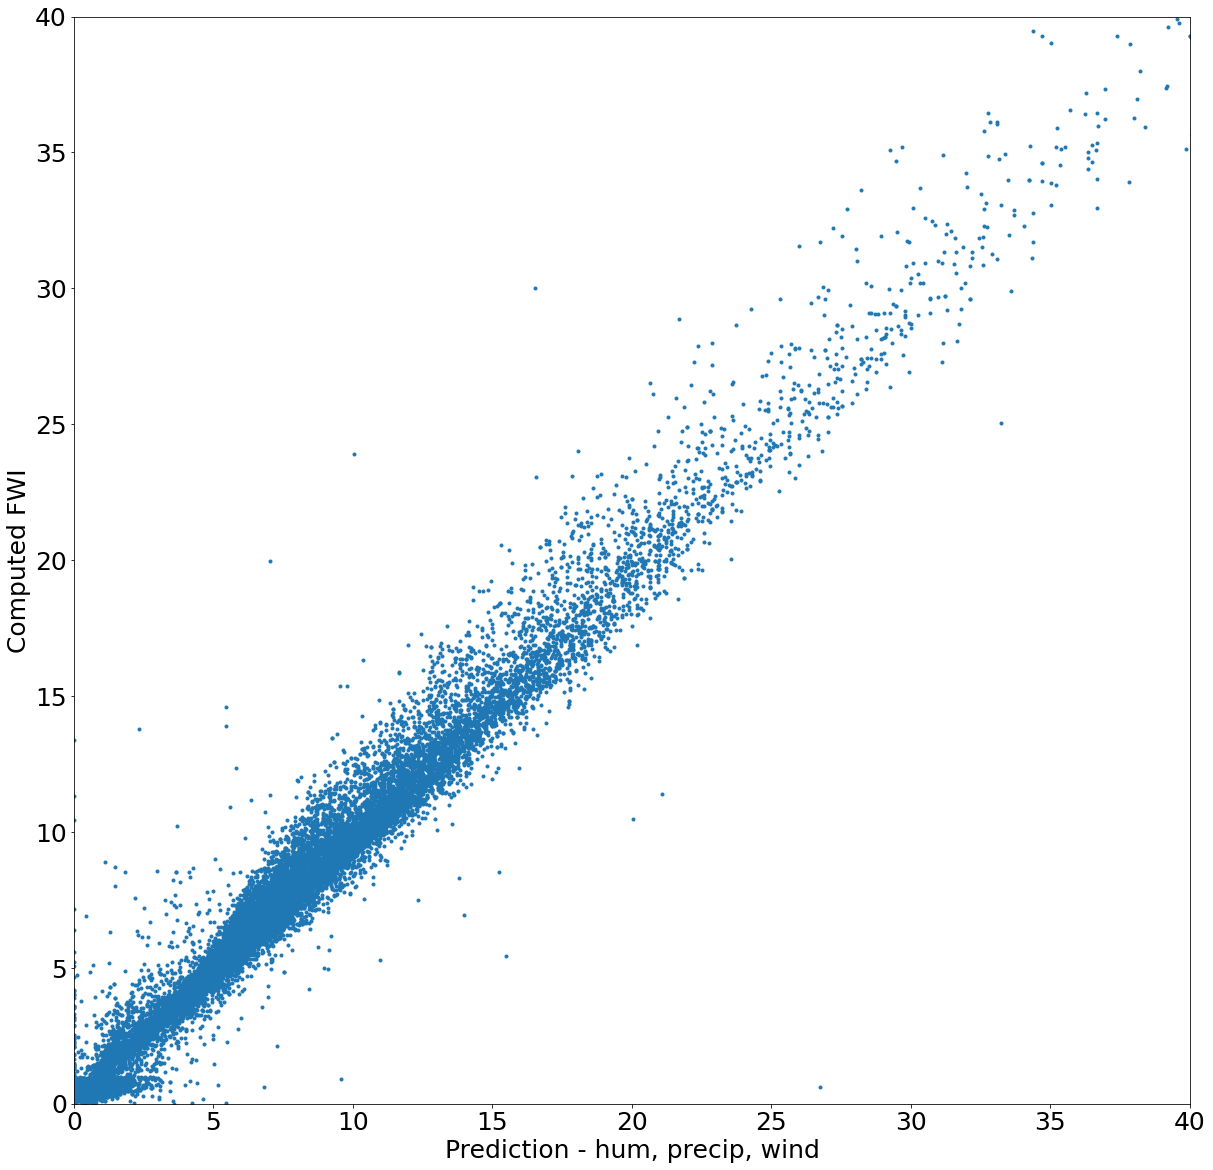

In [22]:


from pylab import *

figure(figsize = (20,20))
plot(model.predict(test_features.reshape(-1,3)), test_labels,".")
xlabel("Prediction - hum, precip, wind",fontsize = 25)
ylabel("Computed FWI",fontsize = 25)
ylim(0,40)
xlim(0,40)

_=xticks(fontsize = 25)
_=yticks(fontsize = 25)